## Setup

In [ ]:
import pandas as pd
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.layers import Input, Activation, LeakyReLU, Dropout
from keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
import warnings
warnings.filterwarnings('ignore')

MAIN_DIR = "../input/brain-mri-images-for-brain-tumor-detection"
SEED = 40

In [ ]:
os.listdir(MAIN_DIR)

['no', 'yes', 'brain_tumor_dataset']

In [ ]:
subdirs = os.listdir(MAIN_DIR)[:2]
for subdir in subdirs:
    print(f"{subdir} contains {len(os.listdir(MAIN_DIR+'/'+subdir))} images")

In [ ]:
def load_images(folder):
    
    imgs = []
    target = 0
    labels = []
    for i in os.listdir(folder):
        subdir = os.path.join(folder, i)
        for j in os.listdir(subdir):
            img_dir = os.path.join(subdir,j)
            try:
                img = cv2.imread(img_dir)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img = cv2.resize(img, (128,128))
                imgs.append(img)
                labels.append(target)
            except:
                continue
        target += 1
    
    imgs = np.array(imgs)
    labels = np.array(labels)
    
    return imgs, labels

In [ ]:
data, labels = load_images(MAIN_DIR)
data.shape, labels.shape

((253, 128, 128), (253,))

In [ ]:
def plot_images(start, end):
    plt.figure(figsize=(22,8))
    for i in range(10):
        axs = plt.subplot(2,5, i+1)
        idx = np.random.randint(start, end)
        plt.imshow(data[idx], cmap='gray')
        plt.axis('on')
        axs.set_xticklabels([])
        axs.set_yticklabels([])
        plt.subplots_adjust(wspace=None, hspace=None)

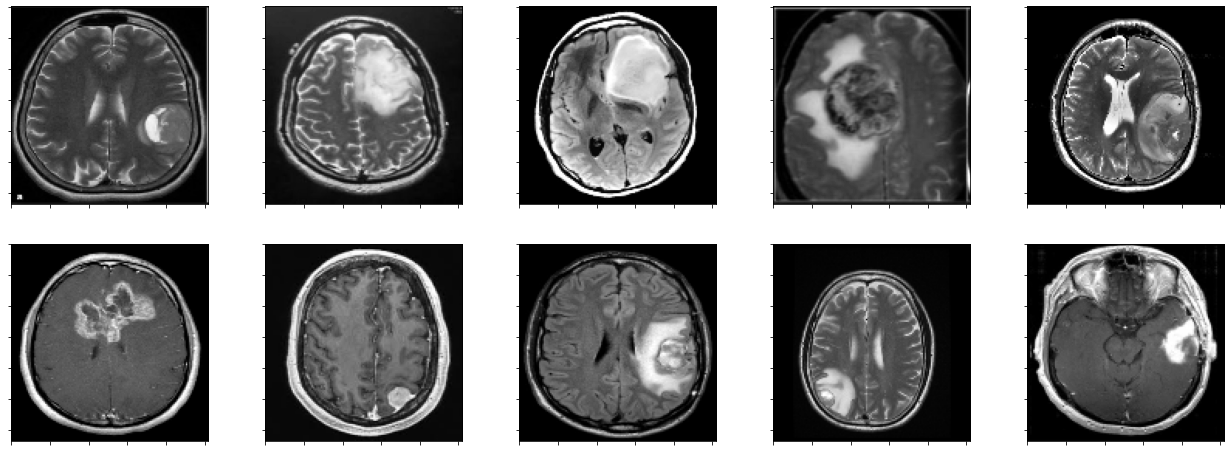

In [ ]:
plot_images(98, 252)  

In [ ]:
norm_data = data / 255. 
norm_data = np.expand_dims(norm_data, axis=3)
norm_data.shape, norm_data[0]

((253, 128, 128, 1),
 array([[[0.01568627],
         [0.01568627],
         [0.01568627],
         ...,
         [0.01176471],
         [0.01176471],
         [0.01176471]],
 
        [[0.01568627],
         [0.01568627],
         [0.01568627],
         ...,
         [0.01568627],
         [0.01568627],
         [0.01568627]],
 
        [[0.01568627],
         [0.01568627],
         [0.01568627],
         ...,
         [0.01568627],
         [0.01568627],
         [0.01568627]],
 
        ...,
 
        [[0.01176471],
         [0.01176471],
         [0.01176471],
         ...,
         [0.01176471],
         [0.01176471],
         [0.01176471]],
 
        [[0.01176471],
         [0.01176471],
         [0.01176471],
         ...,
         [0.01176471],
         [0.01176471],
         [0.01176471]],
 
        [[0.01176471],
         [0.01176471],
         [0.01176471],
         ...,
         [0.01176471],
         [0.01176471],
         [0.01176471]]]))

## Convolutional Neural Network

In [ ]:
tf.random.set_seed(SEED)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=64,
                           kernel_size=3,
                           activation='relu',
                           input_shape=(128,128,1)),
    tf.keras.layers.Conv2D(32,3,activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2,
                              padding='valid'),
    tf.keras.layers.Conv2D(32,3,activation='relu'),
    tf.keras.layers.Conv2D(16,3,activation='relu'),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history = model.fit(norm_data, labels, epochs=10, validation_split=0.20)

Epoch 1/10
7/7 [==============================] - 8s 80ms/step - loss: 0.6505 - accuracy: 0.6188 - val_loss: 0.1729 - val_accuracy: 1.0000
Epoch 2/10
7/7 [==============================] - 0s 21ms/step - loss: 0.6557 - accuracy: 0.6436 - val_loss: 0.6797 - val_accuracy: 0.5098
Epoch 3/10
7/7 [==============================] - 0s 21ms/step - loss: 0.5559 - accuracy: 0.7376 - val_loss: 0.3259 - val_accuracy: 0.9020
Epoch 4/10
7/7 [==============================] - 0s 21ms/step - loss: 0.5401 - accuracy: 0.7426 - val_loss: 0.4780 - val_accuracy: 0.8627
Epoch 5/10
7/7 [==============================] - 0s 23ms/step - loss: 0.5377 - accuracy: 0.7475 - val_loss: 0.3462 - val_accuracy: 0.9608
Epoch 6/10
7/7 [==============================] - 0s 20ms/step - loss: 0.5293 - accuracy: 0.7723 - val_loss: 0.4646 - val_accuracy: 0.8431
Epoch 7/10
7/7 [==============================] - 0s 21ms/step - loss: 0.5000 - accuracy: 0.7624 - val_loss: 0.3338 - val_accuracy: 0.9020
Epoch 8/10
7/7 [===========

## Evaluation

In [ ]:
result = model.evaluate(norm_data, labels, verbose=0)
print(f"Accuracy on Evaluation: {result[1]*100:.2f}%\nLoss: {result[0]:.4f}")

Accuracy on Evaluation: 90.91%
Loss: 0.2555


The Evalutaion is done on the training data itself, which may not present how well the model will do on unseen data\
So now we will make predictions on randomly picked images from the training data and compare the results

In [ ]:
# Generating 20 random numbers to index from data

np.random.seed(SEED)
idxs = np.random.randint(0, 252, 20)

In [ ]:
y_pred_prob = model.predict(norm_data[idxs])
y_pred = np.array([1 if prob>0.5 else 0 for prob in y_pred_prob])

y_true = labels[idxs]
y_pred.shape, y_true.shape

((20,), (20,))

In [ ]:
y_pred

array([0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1])

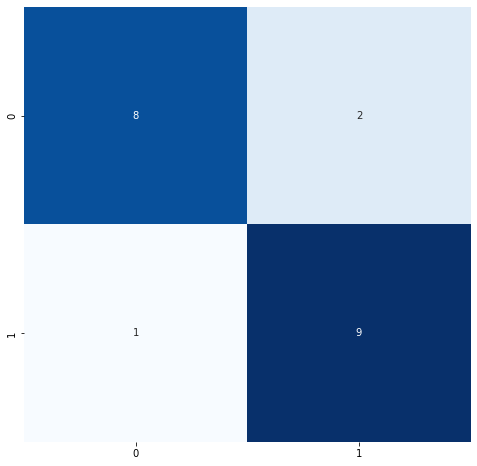

In [ ]:
plt.figure(figsize=(8,8))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, cmap="Blues", annot=True, fmt=".2g", cbar=False)
plt.show()

In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.82      0.90      0.86        10

    accuracy                           0.85        20
   macro avg       0.85      0.85      0.85        20
weighted avg       0.85      0.85      0.85        20



In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 64)      640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 124, 124, 32)      18464     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 58, 58, 16)        4624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 29, 29, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 13456)             0

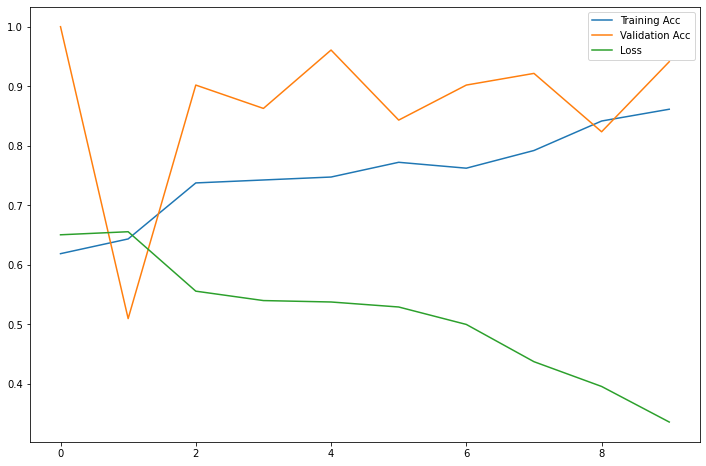

In [ ]:
histdf = pd.DataFrame(history.history)

plt.figure(figsize=(12,8))
plt.plot(histdf['accuracy'], label='Training Acc')
plt.plot(histdf['val_accuracy'], label='Validation Acc')
plt.plot(histdf['loss'], label='Loss')
plt.legend()
plt.show()